## SVD implementation using sklearn and scipy

In [89]:
import pandas as pd
import numpy as np

In [90]:
#reading rating file
r_cols=['user_id','movie_id','rating','timestamp']
ratings=pd.read_csv('ml-1m/ratings.dat',sep='::',names=r_cols,engine='python',encoding='latin-1')
#read movies file.
m_cols=['movie_id','title','genre']
movies=pd.read_csv('ml-1m/movies.dat',sep="::",names=m_cols,engine='python',encoding='latin-1')

In [91]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [92]:
#read movies file.
m_cols=['movie_id','title','genre']
movies=pd.read_csv('ml-1m/movies.dat',sep="::",names=m_cols,engine='python',encoding='latin-1')

In [93]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data and merge in the movie information.
    user_data = ratings[ratings.user_id == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False)
                 )

    print ('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    #print ('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movie_id'].isin(user_full['movie_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations



In [94]:
#Here i am choosing 100k data because of limitation in my laptop's computing power
data=ratings[:100000]
dat=data[0:4]
data.shape

(100000, 4)

In [95]:
n_users = data.user_id.unique().shape[0]
n_items = data.movie_id.unique().shape[0]
print("we have {} users and {} items".format(n_users,n_items))

print("The highest movie-id we have is {}".format(data.movie_id.unique().max()))

we have 669 users and 3264 items
The highest movie-id we have is 3952


In [96]:
um_mat = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
um_mat.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
#from sklearn import cross_validation as cv
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.3)

In [98]:
#creating pivot table to obtain rating matrix
#um_train =train_data.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
um_test =test_data.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)


In [99]:
#data normalisation
R_df = train_data.pivot(index = 'user_id', columns ='movie_id', values = 'rating')
users_mean=np.array(R_df.mean(axis=1))
R_demeaned=R_df.sub(R_df.mean(axis=1), axis=0)
R_demeaned=R_demeaned.fillna(0).as_matrix()
R_demeaned

array([[ 0.76923077,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [100]:


um_testmat=um_test.as_matrix()


In [101]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, true_value):
    
    prediction = prediction[true_value.nonzero()].flatten()
    true_value = true_value[true_value.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, true_value))

In [102]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. 
#Choose k.Number of singular values and vectors to compute.K=6 gives least rmse on test data.
u, s, vt = svds(R_demeaned,k=6)


In [103]:
#By multipying u ,diagonal-matrix(s) and vt gives approximation of rating matrix for k=6.
s_diag_matrix=np.diag(s)
#adding the mean back
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)+ users_mean.reshape(-1, 1)
X_pred

array([[ 4.24281614,  4.23225019,  4.2384973 , ...,  4.23272072,
         4.23166927,  4.23011494],
       [ 3.81708006,  3.71529443,  3.76828655, ...,  3.72414836,
         3.72115979,  3.7090687 ],
       [ 3.95535375,  3.93716517,  3.95074717, ...,  3.94542099,
         3.94407882,  3.93910921],
       ..., 
       [ 3.35493038,  3.16454328,  3.2066439 , ...,  3.19568315,
         3.19824151,  3.23187134],
       [ 3.44543109,  3.37703002,  3.40225916, ...,  3.37632771,
         3.37618088,  3.37320816],
       [ 3.8387128 ,  3.81565874,  3.80995759, ...,  3.81691414,
         3.81792547,  3.81970347]])

In [104]:
#calculating rmse on test data
print('SVD CF RMSE: ' + str(rmse(X_pred, um_testmat)))

SVD CF RMSE: 1.0399620180811575


In [105]:
pred_df = pd.DataFrame(X_pred,columns = R_df.columns)

In [106]:
#recommending 10 movies for user1
already_rated, predictions = recommend_movies(pred_df, 1, movies, ratings, 10)
print("Movies watched by user1")
already_rated.sample(10)


User 1 has already rated 53 movies.
Movies watched by user1


,user_id,movie_id,rating,timestamp,title,genre
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
12,1,2398,4,978302281,Miracle on 34th Street (1947),Drama
11,1,938,4,978301752,Gigi (1958),Musical
6,1,1287,5,978302039,Ben-Hur (1959),Action|Adventure|Drama
35,1,783,4,978824291,"Hunchback of Notre Dame, The (1996)",Animation|Children's|Musical
40,1,1,5,978824268,Toy Story (1995),Animation|Children's|Comedy
49,1,531,4,978302149,"Secret Garden, The (1993)",Children's|Drama
48,1,2028,5,978301619,Saving Private Ryan (1998),Action|Drama|War
8,1,594,4,978302268,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
13,1,2918,4,978302124,Ferris Bueller's Day Off (1986),Comedy


###### Recommended movies

In [108]:
print("Movies recommended for user-1")
predictions

Movies recommended for user-1


,movie_id,title,genre
348,356,Forrest Gump (1994),Comedy|Romance|War
311,318,"Shawshank Redemption, The (1994)",Drama
106,110,Braveheart (1995),Action|Drama|War
1156,1198,Raiders of the Lost Ark (1981),Action|Adventure
2216,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama
579,590,Dances with Wolves (1990),Adventure|Drama|Western
1626,1704,Good Will Hunting (1997),Drama
1513,1584,Contact (1997),Drama|Sci-Fi
2460,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2286,2396,Shakespeare in Love (1998),Comedy|Romance


## SVD and KNN using Surprise library

In [109]:
from surprise import Reader,Dataset,SVD,accuracy
from surprise import KNNBasic
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [110]:
#Loading dataset
reader=Reader()
dat=Dataset.load_from_df(data[['user_id','movie_id','rating']],reader)

In [111]:
trainset,testset=train_test_split(dat,test_size=.3)

In [112]:
kf=KFold(n_splits=8)

In [113]:
svd=SVD()


In [114]:
#k fold cross validation.k=8
for trainset,test in kf.split(dat):
    svd.fit(trainset)
    predictions_svd=svd.test(test)
    print(accuracy.rmse(predictions_svd))
   

RMSE: 0.9207
0.920749705301
RMSE: 0.9240
0.924012016596
RMSE: 0.9215
0.921474896764
RMSE: 0.9230
0.923019208301
RMSE: 0.9256
0.925643035985
RMSE: 0.9206
0.920614200407
RMSE: 0.9287
0.928662581072
RMSE: 0.9279
0.927949232889


In [115]:
#RMSE on test data
pred=svd.test(testset)
print(accuracy.rmse(pred))



RMSE: 0.7139
0.713900624998


In [116]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls




In [117]:
#As mean user rating is 3.5 i am setting threshold as 3.5
precisions,recalls=precision_recall_at_k(pred,k=8,threshold=3.5)

In [118]:
def avg_prec_rec(p,r):
    psum=sum(prec for prec in p.values())/len(p)
    rsum=sum(rec for rec in r.values())/len(r)
    print('precision is {} and recall is {}'.format(psum,rsum))

In [119]:
avg_prec_rec(precisions,recalls)

precision is 0.9166826820414259 and recall is 0.4845804466113489


In [120]:
def p_r_at_thresh(predn):
    p=[0 for x in range(4)]
    r=[0 for x in range(4)]
    for t in np.arange(1,4):
        precisions1,recalls1=precision_recall_at_k(predn,k=10,threshold=t)
        p[t]=sum(prec for prec in precisions1.values())/len(precisions1)
        r[t]=sum(rec for rec in recalls1.values())/len(recalls1)

    #mapped = zip(p,r) 
    #mapped = list(mapped)
    return p,r


In [121]:
#checking the value of precision and recall as threshold is varied
print("Precision,recall values as threshold is varied from 0 to 3")
precision,recall=p_r_at_thresh(pred)
mapped = zip(precision,recall) 
mapped = list(mapped)
print(mapped)

Precision,recall values as threshold is varied from 0 to 3
[(0, 0), (1.0, 0.48126061097354611), (0.98890015896742334, 0.49565739589030133), (0.97832408000569371, 0.50412700685505807)]


In [122]:
import matplotlib.pyplot as plt
%matplotlib inline
def plotting(p,r,alg):
    plt.xlabel('Threshold')
    plt.ylabel('Prec/Rec')
    plt.ylim([0.0, 1.25])
    plt.xlim([0.0, 4.0])
    if alg ==1:
        a="SVD"
    elif alg==2:
        a="KNN"
    
    plt.title('Precision-Recall for %s'%a)
    t =[x for x in range(4)]
    mapped = zip(t,r)
    
    #print(*zip(*mapped))
    plt.plot(*zip(*mapped),label="recall")
    mapped1=zip(t,p)
    
    plt.plot(*zip(*mapped1),label="precision")
    leg = plt.legend(loc=2, ncol=1, mode="expand", shadow=True, fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.show()
#plt.legend(loc=2)


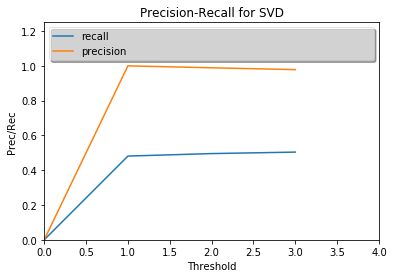

In [123]:
#precision recall at threshold values 1,2,3
plotting(precision,recall,alg=1)

In [124]:
#between 20 and 100 k=20 gave least rmse
algo_knn = KNNBasic(k=20)

In [125]:
from surprise.accuracy import rmse
for trainset, test in kf.split(dat): 
    
    
    algo_knn.fit(trainset)
    predictions_knn = algo_knn.test(test)
    rmse(predictions_knn)               

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9582
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9628
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9540
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9570
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9677
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9534
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9491
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9624


In [126]:
pred1=algo_knn.test(testset)
print(accuracy.rmse(pred1))

RMSE: 0.7515
0.751453577502


In [47]:
from collections import defaultdict
def get_top5_recommendations(predictions, topN = 5):

    top_recs = defaultdict(list)

    for uid, iid, true_r, est, _ in predictions:

        top_recs[uid].append((iid, est))

    for uid, user_ratings in top_recs.items():

        user_ratings.sort(key = lambda x: x[1], reverse = True)

        top_recs[uid] = user_ratings[:topN]

    return top_recs

In [48]:
precisions1,recalls1=precision_recall_at_k(pred1,k=8,threshold=3.5)

In [49]:
print('Average value of precison ,recall at threshold of 3.5')
avg_prec_rec(precisions1,recalls1)

Average value of precison ,recall at threshold of 3.5
precision is 0.94081429283223 and recall is 0.5205849265483787


In [50]:
#precision and recall for knn for thresholds 1,2,3
precision1,recall1=p_r_at_thresh(pred1)
mapped1 = zip(precision1,recall1) 
mapped1 = list(mapped1)
print('precision,recall for KNN as threshold varied from 0 to 3')
print(mapped1)

precision,recall for KNN as threshold varied from 0 to 3
[(0, 0), (1.0, 0.47831615072765865), (0.98900633497046009, 0.49314303230021495), (0.98436662158635202, 0.50443244996799774)]


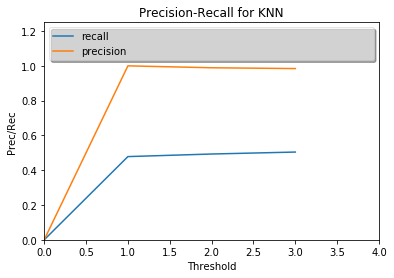

In [51]:
plotting(precision1,recall1,alg=2)

### Top five recommendations for user-1 using KNN

In [86]:
#Top 5 recommendation for userid-1.
top5_recommendknn = get_top5_recommendations(predictions_knn)



In [87]:
for uid, user_ratings in top5_recommendknn.items():
    if(uid==1):
       
        l=[]
        for i,j in user_ratings:
            l.append(i)


In [88]:
mov_rec=movies[movies.movie_id.isin(l)]
print("Top 5 recommendations using KNN")
mov_rec

Top 5 recommendations using KNN


,movie_id,title,genre
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
523,527,Schindler's List (1993),Drama|War
1179,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
2623,2692,Run Lola Run (Lola rennt) (1998),Action|Crime|Romance
2849,2918,Ferris Bueller's Day Off (1986),Comedy


### Top 5 recommendations using SVD for userid-1

In [70]:
top5_recommensvd = get_top5_recommendations(predictions_svd)


In [83]:
for uid, user_ratings in top5_recommensvd.items():
    if(uid==1):
       
        l=[]
        for i,j in user_ratings:
            l.append(i)

In [84]:

mov_rec=movies[movies.movie_id.isin(l)]
print("Top 5 recommendations using SVD")
mov_rec

Top 5 recommendations using SVD


,movie_id,title,genre
604,608,Fargo (1996),Crime|Drama|Thriller
655,661,James and the Giant Peach (1996),Animation|Children's|Musical
907,919,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical
1081,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
2735,2804,"Christmas Story, A (1983)",Comedy|Drama
